In [9]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Creating a PD-controller using Operational Amplifiers

In analog electronics, operational amplifiers are generally used for the realization of Proportional-Integral-Derivating (PID) controllers. While the mathematical model of Linear Time-invariant (LTI) systems assumes ideal conditions, the realistic circuits may not entirely match them.

In most cases, the ideal model returns acceptable results, but the frequency characteristics can be approximated better by expanding the model with the amplifier's open-loop gain:
<br><br>
$$G_{ideal}(s)=\frac{V_{out}}{V_{in}}=-\frac{Z_F}{Z_G}\qquad\qquad G_{approx}(s)=\frac{V_{out}}{V_{in}}=-\frac{\frac{-A\cdot Z_F}{Z_G+Z_F}}{1+\frac{A\cdot Z_G}{Z_G+Z_F}}$$
<br>

In this example, we will explore some of the operational amplifier based PD controller configurations.<br>
<b>First, select an open-loop gain value for the calculations!</b>

In [10]:
# Model selector
opampGain = w.ToggleButtons(
    options=[('10 000', 10000), ('50 000', 50000), ('200 000', 200000),],
    description='Operational amplifier gain: ', style={'description_width':'30%'})

display(opampGain)

ToggleButtons(description='Operational amplifier gain: ', options=(('10 000', 10000), ('50 000', 50000), ('200…

The simplest implementation of the PD controller contains a capacitor in the feedforward and a resistor in the feedback path. The ideal model matches exactly the mathematical form of the controller. But after the inclusion of the open-loop gain, a first-order component appears, serving as a low-pass filter. This form of the PD controller is often used in place of the ideal version when designing applications.
<br><br>
<img src="Images/diff1.png" width="30%" />
<br>
<b>Adjust the passive components so that the non-ideal model is the closest to the ideal! Where does the significant cutoff appear? What can be said about the phase plot?</b>

<IPython.core.display.Javascript object>


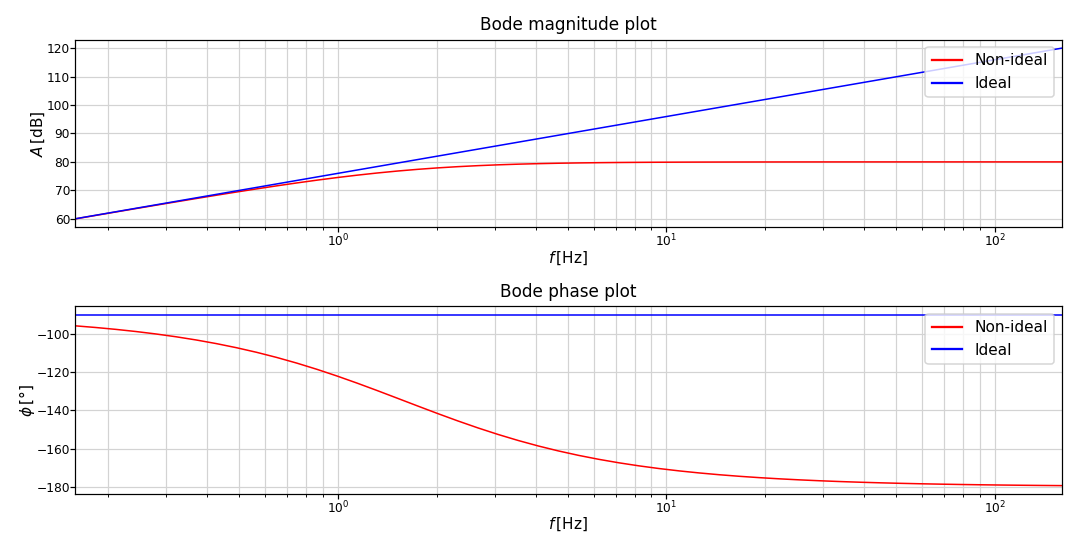

Output()

In [11]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

l1 = f1_ax1.plot([], [], color='red')
l2 = f1_ax2.plot([], [], color='red') 
l3 = f1_ax1.plot([], [], color='blue')
l4 = f1_ax2.plot([], [], color='blue')  

f1_line1 = l1[0]
f1_line2 = l2[0]
f1_line3 = l3[0]
f1_line4 = l4[0]
    
f1_ax1.legend(l1+l3, ['Non-ideal', 'Ideal'], loc=1)
f1_ax2.legend(l2+l4, ['Non-ideal', 'Ideal'], loc=1)

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bode magnitude plot', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode phase plot', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)  

# System model

def system_model(cg, rf, a):

    Rf = rf / 1000      # Convert to Ohm
    Cg = cg * 1000000   # Convert to Farad

    W_ideal = c.tf([-Rf*Cg, 0], [1])
    W_ac = c.tf([-Rf*Cg*a, 0], [Rf*Cg, a+1])
    
    global f1_line1, f1_line2, f1_line3, f1_line4
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f1_line3, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line4, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()

    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
    print('Ideal PD transfer function:')
    print(W_ideal)
    print('\nNon-ideal PD transfer function:')
    print(W_ac)
    
# GUI widgets
    
rf_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cg_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_g$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system_model, {'rf':rf_slider, 'cg':cg_slider, 'a':opampGain})

display(w.HBox([cg_slider, rf_slider]), input_data)

This implementation of the PD controller though really simple, has a few shortcomings, including its high noise sensitivity. To reduce the this problem, a resistor can be included in the feedforward path, while the transfer function of the system keeps its form.
<br><br>
<img src="Images/diff2.png" width="30%" />
<br>
<b>Adjust the passive components so that the non-ideal model is the closest to the ideal! What are the differences compared to the previous model?</b>

<IPython.core.display.Javascript object>


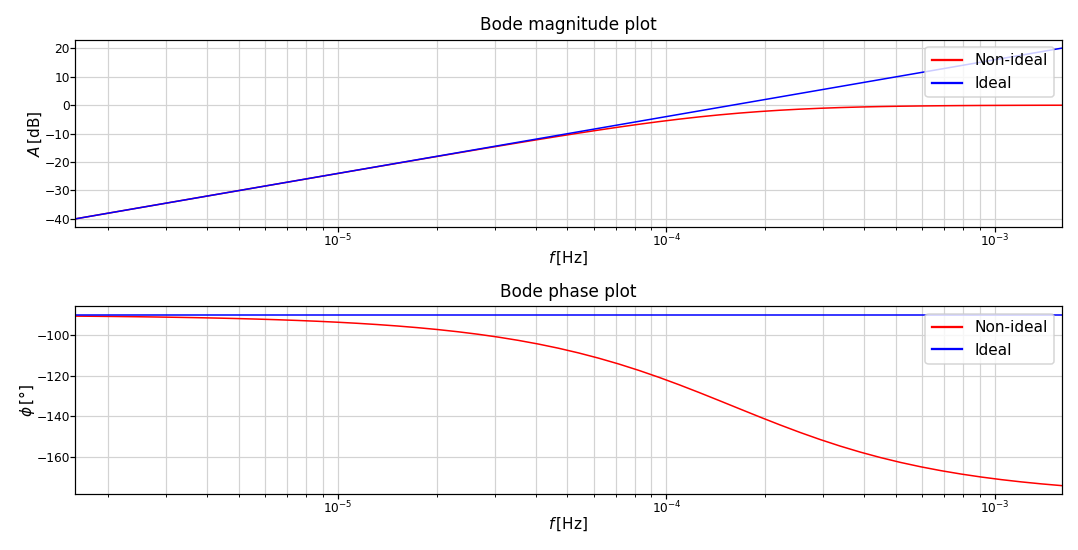

Output()

In [12]:
# Filtered PD - serial (with "stop")

fig2, ((f2_ax1), (f2_ax2)) = plt.subplots(2, 1)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

l1 = f2_ax1.plot([], [], color='red')
l2 = f2_ax2.plot([], [], color='red') 
l3 = f2_ax1.plot([], [], color='blue')
l4 = f2_ax2.plot([], [], color='blue')  

f2_line1 = l1[0]
f2_line2 = l2[0]
f2_line3 = l3[0]
f2_line4 = l4[0]

f2_ax1.legend(l1+l3, ['Non-ideal', 'Ideal'], loc=1)
f2_ax2.legend(l2+l4, ['Non-ideal', 'Ideal'], loc=1)

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='x', tight=True)
f2_ax2.autoscale(enable=True, axis='x', tight=True)
f2_ax1.autoscale(enable=True, axis='y', tight=False)
f2_ax2.autoscale(enable=True, axis='y', tight=False)

f2_ax1.set_title('Bode magnitude plot', fontsize=11)
f2_ax1.set_xscale('log')
f2_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f2_ax2.set_title('Bode phase plot', fontsize=11)
f2_ax2.set_xscale('log')
f2_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

# System model

def system2_model(cg, rg, rf, a):

    Rf = rf / 1000      # Convert to Ohm
    Rg = rg / 1000 
    Cg = cg * 1000000   # Convert to Farad

    W_ideal = c.tf([-Rf*Cg, 0], [1])
    W_ac = c.tf([-Rf*Cg*a, 0], [(Rf+Rg*(a+1))*Cg, a+1])
    
    global f2_line1, f2_line2, f2_line3, f2_line4
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax1.lines.remove(f2_line3)
    f2_ax2.lines.remove(f2_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f2_line1, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f2_line2, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f2_line3, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line4, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f2_ax1.relim()
    f2_ax2.relim()
    
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    
    print('Ideal PD (differentiator with stop) transfer function:')
    print(W_ideal)
    print('\nNon-ideal PD (differentiator with stop) transfer function:')
    print(W_ac)
    
# GUI widgets
    
rg2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_g$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
rf2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$$\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cg2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_g$$\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system2_model, {'rg':rg2_slider, 'rf':rf2_slider, 'cg':cg2_slider, 'a':opampGain})

display(w.HBox([rg2_slider, cg2_slider, rf2_slider]), input_data)